In [2]:
import pytorch_lightning as pl

from pennylane import numpy as np
import torch
from torch import nn
import pennylane as qml
import matplotlib.pyplot as plt

import functools

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [3]:
def deterministic(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        torch.manual_seed(0)
        np.random.seed(0)
        value = func(*args, **kwargs)
        return value
    return wrapper

(<Figure size 1400x500 with 1 Axes>, <Axes: >)

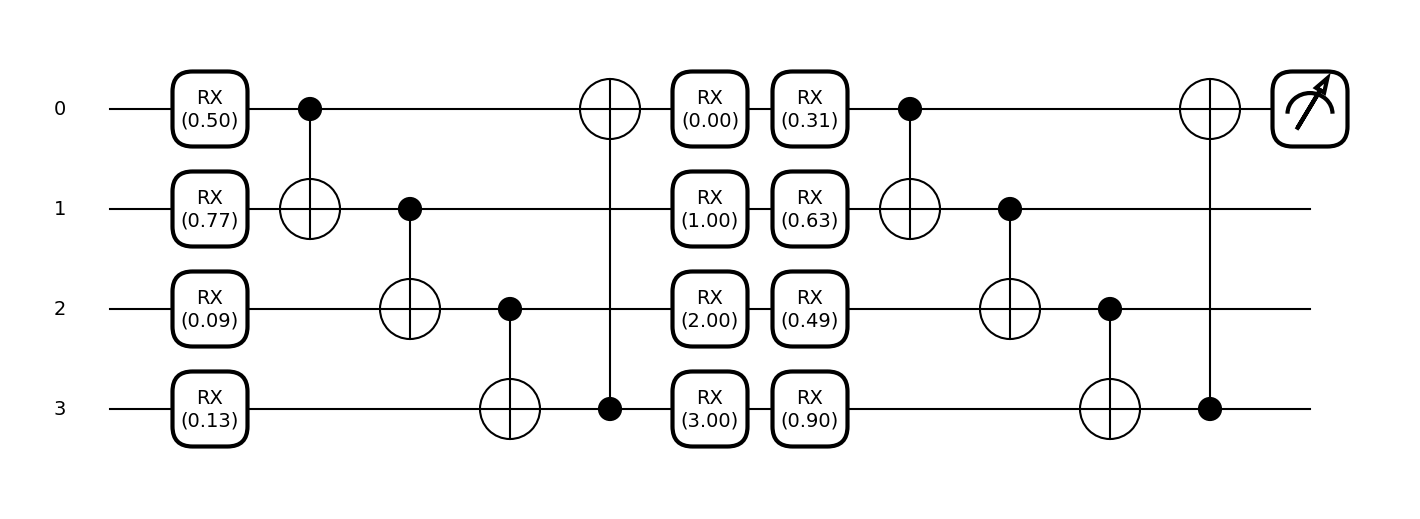

In [4]:
n_qubits = 4
n_depth = 1
n_layers = 1
in_dim = n_qubits * n_depth
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
@deterministic
def circuit(inputs, w):
    qml.BasicEntanglerLayers(w[0], wires=range(n_qubits), rotation=qml.RX)
    
    for i in range(n_depth):
        qml.AngleEmbedding(features=inputs[i*n_qubits : (i+1)*n_qubits],
                           wires=range(n_qubits),
                           rotation="X")
        qml.BasicEntanglerLayers(w[i+1],
                                 wires=range(n_qubits),
                                 rotation=qml.RX)
        
    return [qml.expval(qml.PauliZ(k)) for k in range(1)]

weight_shapes = {"w": (n_depth+1, n_layers, n_qubits)}

qml.draw_mpl(circuit, decimals=2, expansion_strategy='device')(inputs=torch.arange(n_qubits*n_depth, dtype=float),
                                                               w=torch.rand(weight_shapes["w"]))

In [5]:
class FreqNet(pl.LightningModule):
    @deterministic
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        
    def training_step(self, batch, batch_idx):
        X = batch
        
        
    
    def forward(self, X):
        X = X.view(-1, 1)
        X = X.expand(-1, in_dim)
        X = self.qlayer(X).view(-1, 1)
        return X

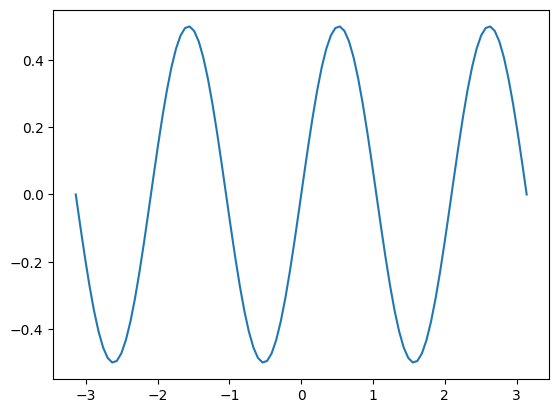

In [6]:
f = lambda x: 0.5 * np.sin(3*x)
x = np.linspace(-np.pi, np.pi, 100)
plt.plot(x, f(x))